In [16]:
import Pkg
Pkg.activate("..")

using IJulia

projdir = pwd()  # if you're currently in the project directory
# alternatively: projdir = dirname(Base.active_project())

IJulia.installkernel("Julia (my project, clean libs)";
    env = Dict(
        "JULIA_PROJECT"   => projdir,  # forces *your* project
        "LD_LIBRARY_PATH" => "",       # prevents system/conda libs overriding JLLs
        "LD_PRELOAD"      => ""
    )
)


  Activating project at `~/Projects/bind_RBM`
[ Info: Installing 'Julia (my project, clean libs) 1.12' kernelspec in /home/jboccato/.local/share/jupyter/kernels/julia-_my-project_-clean-libs_-1.12


"/home/jboccato/.local/share/jupyter/kernels/julia-_my-project_-clean-libs_-1.12"

In [17]:
import Pkg
Pkg.activate("..")
Pkg.instantiate()


  Activating project at `~/Projects/bind_RBM`


In [18]:
using CairoMakie
using RestrictedBoltzmannMachines: sample_from_inputs, inputs_h_from_v, mean_from_inputs
using DelimitedFiles, LinearAlgebra, Statistics, Random
using RestrictedBoltzmannMachines: RBM, Potts, Binary, ReLU, nsReLU, log_pseudolikelihood, initialize!, pcd!,
             sample_v_from_v, free_energy, onehot_encode, sample_h_from_v
using Statistics: mean, cov, std, var, cor
using LinearAlgebra: norm
const ALPHABET = "ACDEFGHIKLMNPQRSTVWY-"
alphabet_dict = Dict(c => i for (i, c) in enumerate(ALPHABET))
split_idx = 81
using JLD2
using MultivariateStats
using MLJ, MLJLinearModels
using Random: MersenneTwister, shuffle, bitrand
using DataFrames
using Logging
using SequenceLogos
using XLSX
alphabet = collect("ACDEFGHIKLMNPQRSTVWY-")
using bind_RBM: plot_model_vs_data, create_binding_dictionary_Gogl, create_binding_dictionary, score_strings, parse_rules_file, best_strings_per_class, collect_key_label_hits_per_class, onehot_encode_2d,
                plot_matrix_logo

In [19]:
data_Gogl = create_binding_dictionary_Gogl("/home/jboccato/Projects/bind_RBM/artifacts/data/labelled/PDZ_2022.xlsx", "/home/jboccato/Projects/bind_RBM/artifacts/data/labelled/PDZ_2022_final.xlsx", 4)
data_Stiffler = create_binding_dictionary("/home/jboccato/Projects/bind_RBM/artifacts/data/labelled/output.txt")


Skipped rows: 2037


Dict{String, @NamedTuple{elements::Vector{String}, labels::Vector{Int64}}} with 84 entries:
  "----------GFGIAISGGRDNP… => (elements = ["NSLDKLKTDC", "VDFPPKESSL", "VDLLPK…
  "----------GLGFSIAGGVGNQ… => (elements = ["NSLDKLKTDC", "VDFPPKESSL", "VDLLPK…
  "----------SLGLSIAGGVGSP… => (elements = ["NSLDKLKTDC", "VDFPPKESSL", "VDLLPK…
  "----------PWGFRLQGGKDFN… => (elements = ["NSLDKLKTDC", "VDFPPKESSL", "VDLLPK…
  "----------GLGFSIAGGVGNQ… => (elements = ["NSLDKLKTDC", "VDFPPKESSL", "VDLLPK…
  "----------FLGISIVGQSNER… => (elements = ["NSLDKLKTDC", "VDFPPKESSL", "VDLLPK…
  "----------GFGLTVSG--DN-… => (elements = ["NSLDKLKTDC", "VDFPPKESSL", "VDLLPK…
  "----------GLGLSIVGKRSGS… => (elements = ["NSLDKLKTDC", "VDFPPKESSL", "VDLLPK…
  "-----KKDSEGFGFVLRGAKAQT… => (elements = ["NSLDKLKTDC", "VDFPPKESSL", "VDLLPK…
  "----------GLGFSILDYQDPI… => (elements = ["NSLDKLKTDC", "VDFPPKESSL", "VDLLPK…
  "-VKLFK-NSSGLGFSFSREDNLI… => (elements = ["NSLDKLKTDC", "VDFPPKESSL", "VDLLPK…
  "----------GLGF

I want to see the performance of the linear classifier on the whole dataset as a function of the L1 regularization

In [20]:
σ(z) = 1 ./ (1 .+ exp.(-z))

# Assume X is (d, N), y is (N,)
# Pack parameters as w = [w₁…w_d; b]  (last entry is bias)
# L1 applies to weights only (not bias) by default.

function neg_loglik(w, X, y; λ::Real=0.0)
    d = size(X, 1)
    @views wb = w[1:d]
    b = w[end]

    z = vec(wb' * X) .+ b          # (N,)
    p = σ(z)
    p = clamp.(p, eps(eltype(p)), 1 - eps(eltype(p)))  # avoid log(0)

    data = -mean(y .* log.(p) .+ (1 .- y) .* log.(1 .- p))
    reg  = λ * sum(abs, wb)        # L1 (weights only)
    return data + reg
end

function neg_loglik_grad!(G, w, X, y; λ::Real=0.0)
    d, N = size(X)
    @views wb = w[1:d]
    b = w[end]

    z = vec(wb' * X) .+ b          # (N,)
    p = σ(z)
    r = p .- y                      # (N,)

    @views G[1:d] .= (X * r) / N .+ λ .* sign.(wb)   # L1 subgradient
    G[end] = mean(r)                                  # bias gradient
    return G
end


neg_loglik_grad! (generic function with 1 method)

In [21]:
using Optim
using Statistics

results = String[]
class_array= Int[]


for (key, value) in data_Gogl
    for (element, label) in zip(value.elements, value.labels)
        if label == 0 || label == 1
            push!(results, key * element)
            push!(class_array, label)
        end
    end
end
full_label = onehot_encode_2d(results, alphabet, alphabet_dict)


1911×68442 Matrix{Float32}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  

In [ ]:
d = size(full_label, 1)

# NOTE: if you added a bias as last parameter, w must be length d+1
w0 = 0.01 .* randn(d + 1)

# values to sweep (edit as you like)
λ_grid = 10.0 .^ range(-6, 1; length=12)   # 1e-6 ... 1e1

results = NamedTuple[]
for λ in λ_grid
    res = optimize(
        w -> neg_loglik(w, full_label, class_array; λ=λ),
        (G, w) -> neg_loglik_grad!(G, w, full_label, class_array; λ=λ),
        copy(w0),
        BFGS();
        autodiff = :false
    )

    ŵ = Optim.minimizer(res)

    # predictions (with bias packed as last parameter)
    @views wb = ŵ[1:d]
    b = ŵ[end]
    z = vec(wb' * full_label) .+ b
    p = σ(z)
    ŷ = Int.(p .>= 0.5)
    y_int = Int.(class_array)

    TP = sum((y_int .== 1) .& (ŷ .== 1))
    TN = sum((y_int .== 0) .& (ŷ .== 0))
    FP = sum((y_int .== 0) .& (ŷ .== 1))
    FN = sum((y_int .== 1) .& (ŷ .== 0))

    acc  = (TP + TN) / length(y_int)
    prec = TP / max(TP + FP, 1)
    rec  = TP / max(TP + FN, 1)
    spec = TN / max(TN + FP, 1)
    f1   = 2 * prec * rec / max(prec + rec, 1e-10)
    auc  = compute_auc(y_int, Float32.(p))

    push!(results, (
        λ=λ, acc=acc, prec=prec, rec=rec, spec=spec, f1=f1, auc=auc,
        TP=TP, TN=TN, FP=FP, FN=FN, iters=Optim.iterations(res),
        fmin=Optim.minimum(res), converged=Optim.converged(res)
    ))

    println("λ=$(λ): acc=$(round(acc, digits=4)) f1=$(round(f1, digits=4)) auc=$(round(auc, digits=4)) converged=$(Optim.converged(res))")
end


# optional: pretty print a small table
println("\nλ\t\tacc\tf1\tauc")
for r in results
    println("$(r.λ)\t$(round(r.acc, digits=4))\t$(round(r.f1, digits=4))\t$(round(r.auc, digits=4))")
end


In [4]:
function unique_elements_from_dict(d::Dict)
    uniq = Set{String}()
    for v in values(d)
        union!(uniq, v.elements)
    end
    return uniq
end

uniq_Gogl     = unique_elements_from_dict(data_Gogl)
uniq_Stiffler = unique_elements_from_dict(data_Stiffler)

common = intersect(uniq_Gogl, uniq_Stiffler)
n_common = length(common)

println("Unique elements in common: ", n_common)

function filter_dict_by_elements(d::Dict, common_elements::Set{String})
    out = Dict{eltype(keys(d)), eltype(values(d))}()

    for (k, v) in d
        filtered = [e for e in v.elements if e in common_elements]

        if !isempty(filtered)
            # reconstruct named tuple, replacing only `elements`
            out[k] = merge(v, (elements = filtered,))
        end
    end

    return out
end


filtered_Gogl     = filter_dict_by_elements(data_Gogl, common)
filtered_Stiffler = filter_dict_by_elements(data_Stiffler, common)

union_dict = merge(filtered_Gogl, filtered_Stiffler)
union_tot = merge(data_Gogl, data_Stiffler)

Unique elements in common: 53


Dict{String, @NamedTuple{elements::Vector{String}, labels::Vector{Int64}}} with 338 entries:
  "-------GPAPWGFRLQGGKDFN… => (elements = ["DTLEKFVEGL", "RRSQSRESQC", "SSRTRR…
  "----------GLGFSIAGGVGNQ… => (elements = ["NSLDKLKTDC", "VDFPPKESSL", "VDLLPK…
  "-VTLEK-MSAGLGFSLEGGKGSL… => (elements = ["SKSLERATQL", "LLQEEWETVM", "THREVK…
  "-----------------------… => (elements = ["DTLEKFVEGL", "RRSQSRESQC", "SSRTRR…
  "-VELTK-NVQGLGITIAGYIGDK… => (elements = ["SSIDLWETAL", "STLTIFETAL", "DTLEKF…
  "-------DGGPLGIHVVPFSARG… => (elements = ["EPTTTTSVPL", "SSEGVPDLLV", "DTLEKF…
  "-----TVSGNGLGIRIVGGKEIP… => (elements = ["RSLEEEESQL", "EMDRRPATVV", "DPRNTQ…
  "-------KNPGLGFSISGGISGQ… => (elements = ["HYPASPDSWV", "QYPGSPDSWV", "PLPPEE…
  "-IELEK-GSKGLGFSILDYQDPI… => (elements = ["SVISRREWYV", "QKNKDREYYV", "GDSSRK…
  "----------GLGFSIAGGVGNQ… => (elements = ["NSLDKLKTDC", "VDFPPKESSL", "VDLLPK…
  "-VTLKRDPHRGFGFVINEGEYSG… => (elements = ["LHLHGTGIQV", "SVISRREWYV", "DSATVR…
  "-VVLTADPVTGFG

In [14]:
# Or flatten into a single vector of all elements
all_elements_flat = vcat([value.elements for value in values(union_dict)]...)
file_content = read("/home/jboccato/Projects/bind_RBM/artifacts/peptides/peptides.txt", String)

peptides_common = score_strings(file_content, all_elements_flat)


Dict{String, Vector{Float64}} with 53 entries:
  "RSSGGDDFWF" => [0.0, 0.2, 0.2, 0.666667, 0.75, 1.0, 0.166667, 0.4, 0.166667,…
  "DSEEELPTRL" => [0.0, 0.0, 0.2, 0.166667, 0.25, 0.25, 0.166667, 0.0, 0.5, 0.6…
  "PDSNPEESSV" => [0.4, 0.2, 0.2, 0.333333, 0.25, 0.5, 0.166667, 0.0, 0.5, 0.2,…
  "EFKQTSSFLV" => [0.2, 0.4, 0.4, 0.5, 0.75, 0.5, 0.333333, 0.0, 0.166667, 0.0,…
  "SRPRPDDLEI" => [0.0, 0.0, 0.4, 0.5, 0.5, 0.75, 0.166667, 0.0, 0.166667, 0.0,…
  "NKSEPFLTWL" => [0.0, 0.0, 0.2, 0.333333, 0.75, 0.5, 0.5, 0.6, 0.333333, 0.6,…
  "KPDKQEEFYA" => [0.0, 0.2, 0.2, 0.5, 0.5, 0.75, 0.0, 0.0, 0.166667, 0.2, 0.33…
  "RQKEVRESKC" => [0.6, 0.0, 0.0, 0.333333, 0.0, 0.25, 0.0, 0.0, 0.5, 0.4, 0.33…
  "KKNKDKEYYV" => [0.4, 0.2, 0.4, 0.666667, 0.75, 1.0, 0.166667, 0.0, 0.5, 0.2,…
  "ASGLDKRDYV" => [0.4, 0.2, 0.2, 0.5, 0.5, 0.5, 0.333333, 0.0, 0.333333, 0.0, …
  "AHGSTRDQSI" => [0.2, 0.0, 0.2, 0.333333, 0.25, 0.5, 0.166667, 0.0, 0.5, 0.0,…
  "DTKNYKQTSV" => [0.6, 0.2, 0.2, 0.333333, 0.25, 0.25, 0.1666

In [6]:
using CairoMakie

function plot_histograms(results)
    all_scores = collect(values(results))
    n_classes = length(all_scores[1])
    
    fig = CairoMakie.Figure(resolution = (1200, 1000))
    
    for i in 1:n_classes
        row = div(i - 1, 4) + 1
        col = mod(i - 1, 4) + 1
        
        class_scores = [scores[i] for scores in all_scores]
        
        ax = Axis(fig[row, col], xlabel = "Score", ylabel = "Count", title = "CLASS $i")
        hist!(ax, class_scores, bins = 20, color = (:blue, 0.5))
    end
    
    fig
end

plot_histograms (generic function with 1 method)

In [5]:
# Or flatten into a single vector of all elements
all_elements_union = vcat([value.elements for value in values(union_tot)]...)
file_content = read("/home/jboccato/Projects/bind_RBM/artifacts/peptides/peptides.txt", String)

peptides_full = score_strings(file_content, all_elements_union)
plot_histograms(peptides_full)

LoadError: UndefVarError: `union_tot` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie ~/.julia/packages/Makie/Vn16E/src/scenes.jl:264


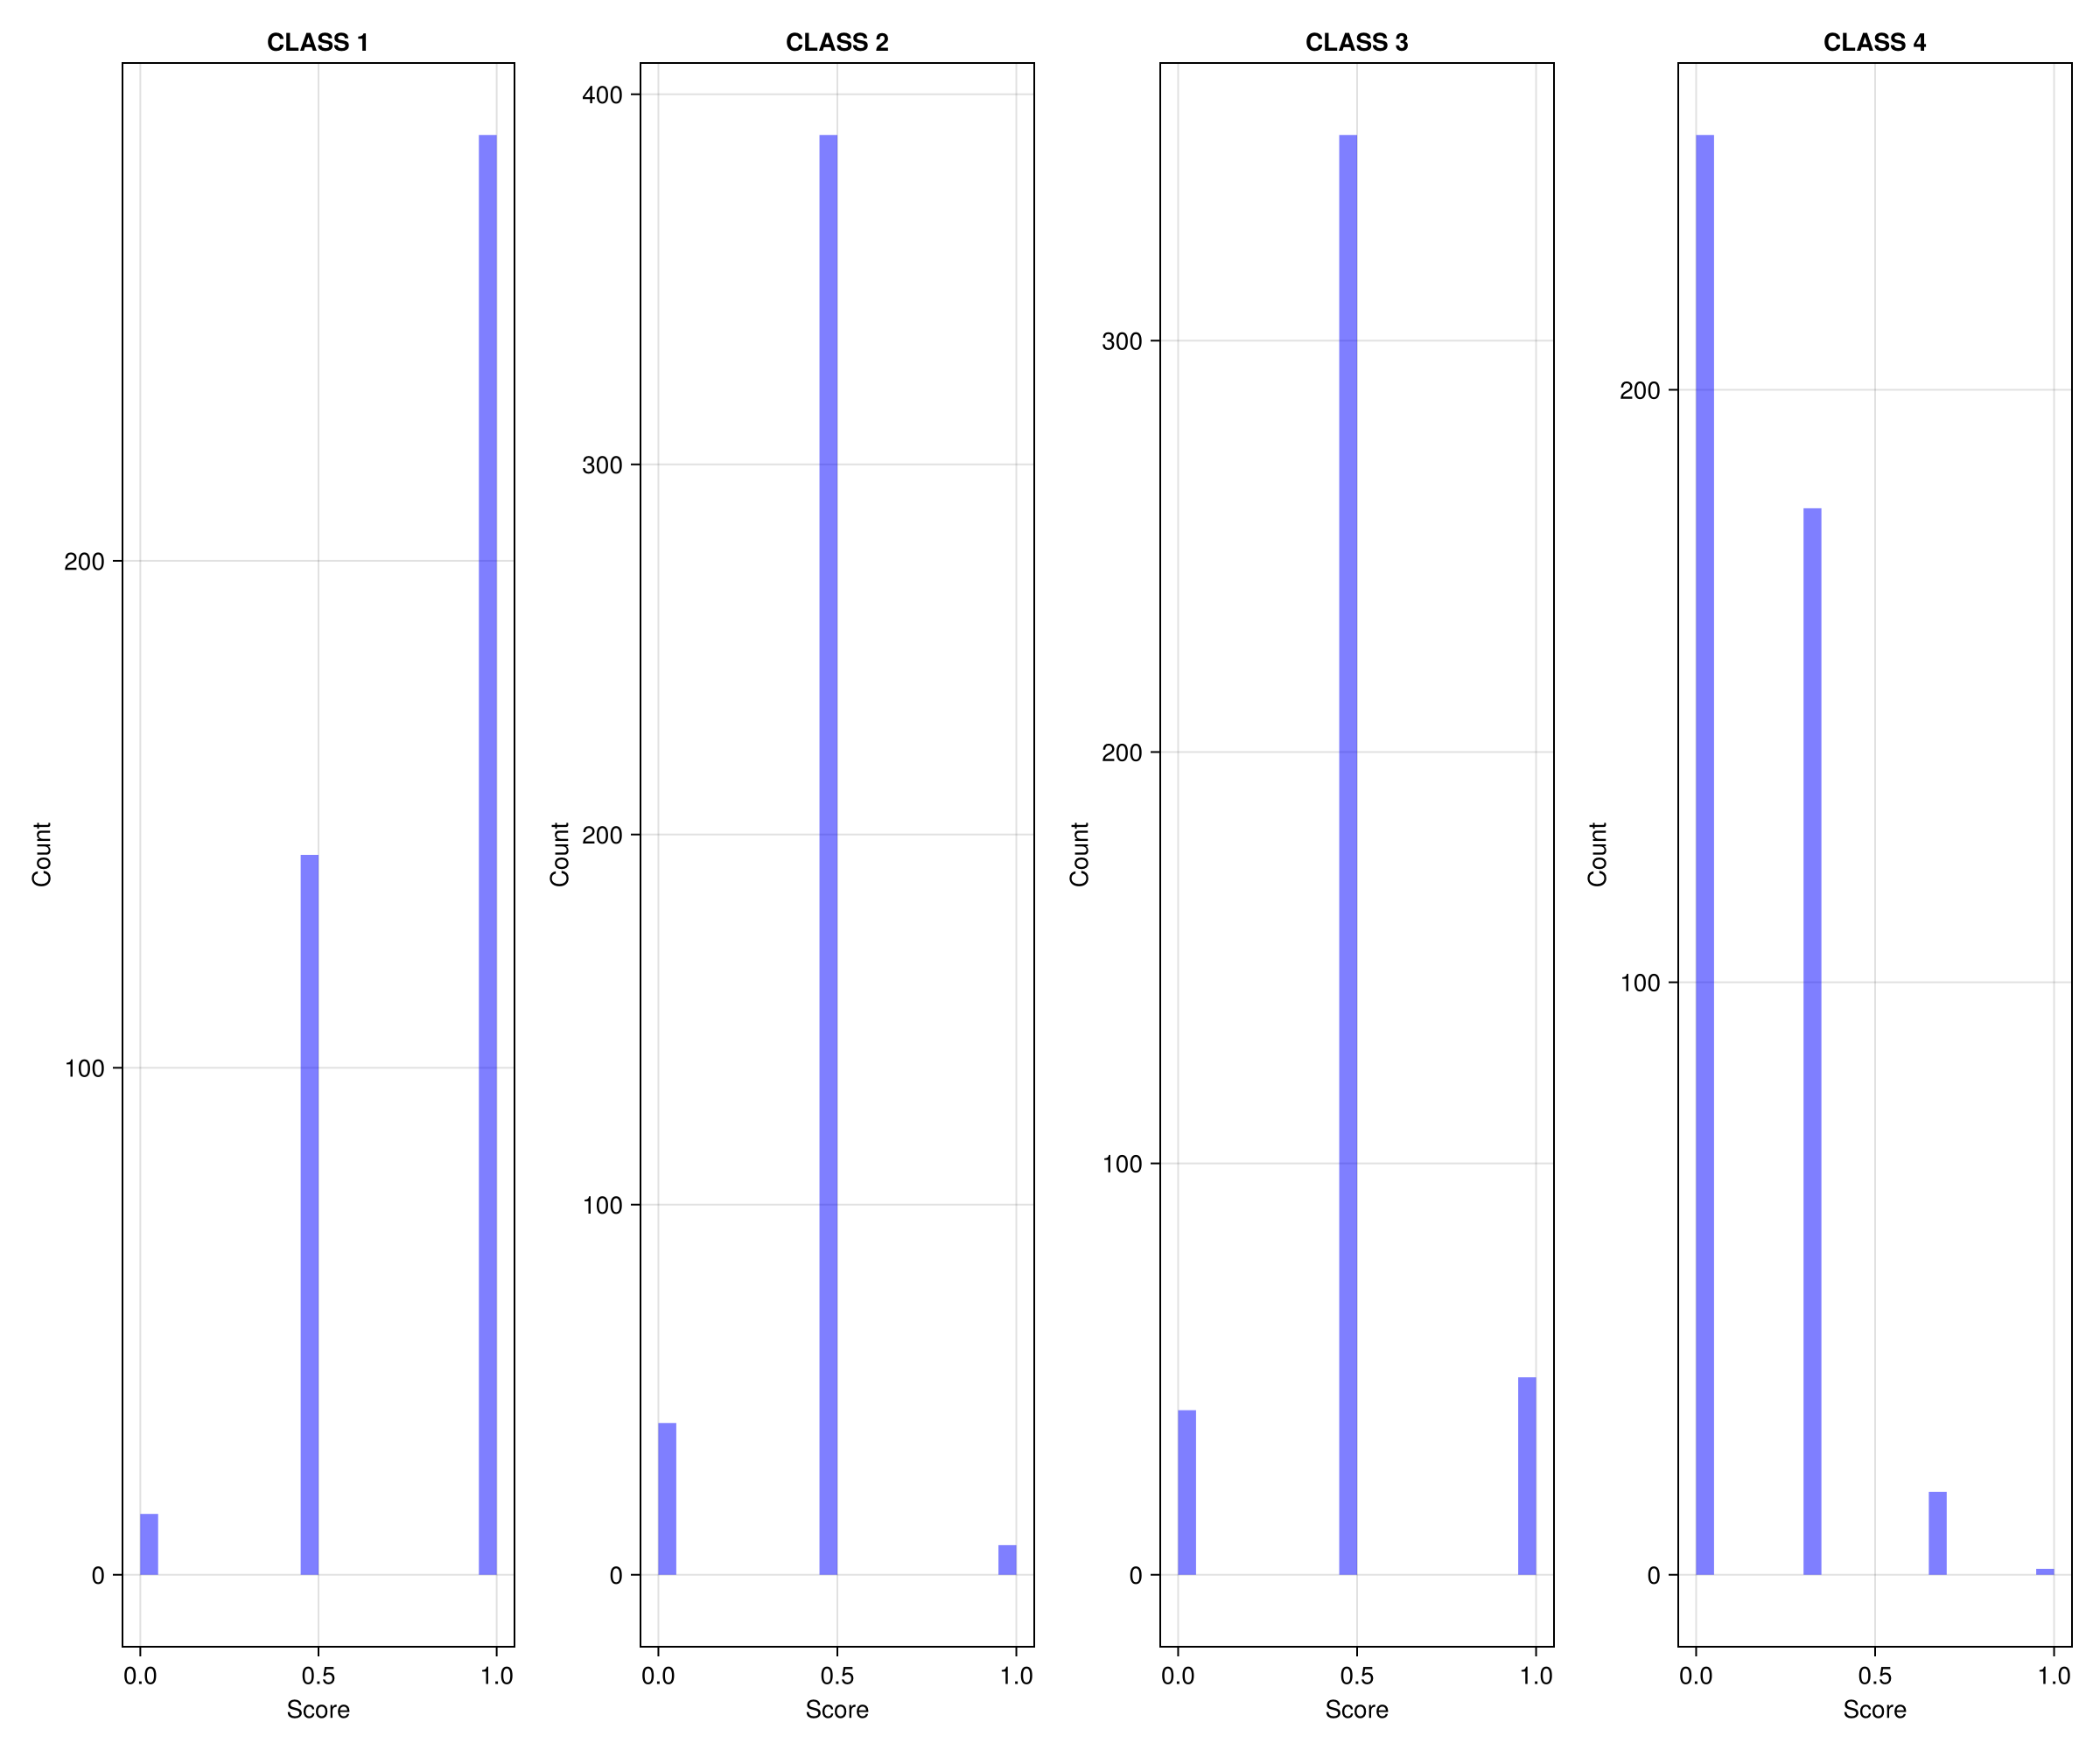

In [7]:
# Or flatten into a single vector of all elements
all_elements_Gogl = vcat([value.elements for value in values(data_Gogl)]...)
file_content = read("/home/jboccato/Projects/bind_RBM/artifacts/peptides/peptides4.txt", String)

peptides_full = score_strings(file_content, all_elements_Gogl)
plot_histograms(peptides_full)

In [8]:
dict = best_strings_per_class(file_content, all_elements_Gogl)
indexed, by_class = collect_key_label_hits_per_class(dict, data_Gogl)


((class_names = ["#CLASS 1", "#CLASS 2", "#CLASS 3", "#CLASS 4"], class_to_idx = Dict("#CLASS 1" => 1, "#CLASS 3" => 3, "#CLASS 4" => 4, "#CLASS 2" => 2), keys_by_class = [["-------GPAPWGFRLQGGKDFN-MPLTISSLKDGKAAQAN-VRIGDVVLSIDGINAQGMTHLEAQNKIKGCTGSLNMTLQ", "-------GPAPWGFRLQGGKDFN-MPLTISSLKDGKAAQAN-VRIGDVVLSIDGINAQGMTHLEAQNKIKGCTGSLNMTLQ", "-------GPAPWGFRLQGGKDFN-MPLTISSLKDGKAAQAN-VRIGDVVLSIDGINAQGMTHLEAQNKIKGCTGSLNMTLQ", "-------GPAPWGFRLQGGKDFN-MPLTISSLKDGKAAQAN-VRIGDVVLSIDGINAQGMTHLEAQNKIKGCTGSLNMTLQ", "-------GPAPWGFRLQGGKDFN-MPLTISSLKDGKAAQAN-VRIGDVVLSIDGINAQGMTHLEAQNKIKGCTGSLNMTLQ", "-------GPAPWGFRLQGGKDFN-MPLTISSLKDGKAAQAN-VRIGDVVLSIDGINAQGMTHLEAQNKIKGCTGSLNMTLQ", "-------GPAPWGFRLQGGKDFN-MPLTISSLKDGKAAQAN-VRIGDVVLSIDGINAQGMTHLEAQNKIKGCTGSLNMTLQ", "-------GPAPWGFRLQGGKDFN-MPLTISSLKDGKAAQAN-VRIGDVVLSIDGINAQGMTHLEAQNKIKGCTGSLNMTLQ", "-------GPAPWGFRLQGGKDFN-MPLTISSLKDGKAAQAN-VRIGDVVLSIDGINAQGMTHLEAQNKIKGCTGSLNMTLQ", "-------GPAPWGFRLQGGKDFN-MPLTISSLKDGKAAQAN-VRIGDVVLSIDGINAQGMT

In [9]:
using LinearAlgebra
using Optim

@inline sigmoid(z) = 1 / (1 + exp(-z))

function train_binary_models_per_class(indexed::NamedTuple,
                                          alphabet::Vector{Char},
                                          char_to_index::Dict{Char,Int};
                                          λ::Float64 = 300.0,
                                          maxiters::Int = 300,
                                          smooth_l1::Bool = true,
                                          ϵ_l1::Float64 = 1e-8)

    class_names     = indexed.class_names
    class_to_idx    = indexed.class_to_idx
    keys_by_class   = indexed.keys_by_class
    labels_by_class = indexed.labels_by_class

    models_vec = Vector{Any}(undef, length(class_names))
    models_by_class = Dict{String, Any}()

    opts = Optim.Options(iterations = maxiters)

    for i in eachindex(class_names)
        cname = class_names[i]
        keys  = keys_by_class[i]
        yint  = labels_by_class[i]

        if isempty(keys)
            m = (status=:empty,)
            models_vec[i] = m
            models_by_class[cname] = m
            continue
        end

        # --- checks ---
        L = length(keys[1])
        @assert all(length(s) == L for s in keys) "Class $cname: keys have different lengths"
        @assert all(v -> (v == 0 || v == 1), yint) "Class $cname: labels must be 0/1 only"

        if all(v -> v == 0, yint) || all(v -> v == 1, yint)
            m = (status=:degenerate, only_label=yint[1])
            models_vec[i] = m
            models_by_class[cname] = m
            continue
        end

        for s in keys, c in s
            @assert haskey(char_to_index, c) "Class $cname: character '$c' not in char_to_index"
        end

        y = Float64.(yint)  # 0/1
        X = Float64.(onehot_encode_2d(keys, alphabet, char_to_index))  # (D,N)
        D, N = size(X)
        @assert length(y) == N "Class $cname: labels length != number of samples"

        θ0 = zeros(Float64, D + 1)  # [w; b]

        function f(θ)
            w = @view θ[1:D]; b = θ[D+1]
            z = vec(w' * X) .+ b

            eps = 1e-12
            loss = 0.0
            @inbounds for j in 1:N
                p = clamp(sigmoid(z[j]), eps, 1 - eps)
                loss += -(y[j]*log(p) + (1-y[j])*log(1-p))
            end
            loss /= N

            # ---- L1 regularization on weights only ----
            if smooth_l1
                pen = 0.0
                @inbounds for k in 1:D
                    pen += sqrt(w[k]*w[k] + ϵ_l1)   # ≈ |w[k]|
                end
                loss += λ * pen
            else
                loss += λ * sum(abs, w)            # true L1 (nonsmooth)
            end

            return loss
        end

        function g!(G, θ)
            w = @view θ[1:D]; b = θ[D+1]
            z = vec(w' * X) .+ b

            err = similar(z)
            @inbounds for j in 1:N
                err[j] = sigmoid(z[j]) - y[j]
            end

            gw = (X * err) ./ N

            # ---- gradient / subgradient for L1 term ----
            if smooth_l1
                @inbounds for k in 1:D
                    G[k] = gw[k] + λ * (w[k] / sqrt(w[k]*w[k] + ϵ_l1))
                end
            else
                @inbounds for k in 1:D
                    # subgradient of |w|: sign(w), using 0 at exactly 0
                    G[k] = gw[k] + λ * sign(w[k])
                end
            end

            G[D+1] = sum(err) / N  # bias gradient (no regularization)
            return nothing
        end

        res = Optim.optimize(f, g!, θ0, Optim.LBFGS(), opts)
        θ̂ = Optim.minimizer(res)

        ŵ = θ̂[1:D]
        b̂ = θ̂[D+1]

        m = (status=:ok, w=ŵ, b=b̂, optim=res)
        models_vec[i] = m
        models_by_class[cname] = m
    end

    pack = (class_names=class_names, class_to_idx=class_to_idx, models=models_vec)
    return models_by_class, pack
end

predict_proba(model, X::AbstractMatrix) = vec(sigmoid.(model.w' * X .+ model.b))
predict_label(model, X::AbstractMatrix; threshold=0.5) =
    map(p -> p ≥ threshold ? 1 : 0, predict_proba(model, X))


predict_label (generic function with 1 method)

In [10]:
models_by_class, pack = train_binary_models_per_class(indexed, alphabet, alphabet_dict;
                                                      λ=5.0, maxiters=400)


(Dict{String, Any}("#CLASS 1" => (status = :ok, w = [0.0, 0.0, 0.0, 2.3442792095446515e-8, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 3.206519800898735e-8, -5.0162251681388375e-8, 0.0, 0.0, 0.0, 0.0, 0.0, 9.043466766710671e-8], b = -1.7488502965656463, optim =  * Status: success

 * Candidate solution
    Final objective value:     1.270061e+00

 * Found with
    Algorithm:     L-BFGS

 * Convergence measures
    |x - x'|               = 1.61e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 9.18e-10 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.41e-13 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.11e-13 ≰ 0.0e+00
    |g(x)|                 = 3.29e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   4  (vs limit Inf)
    Iterations:    18
    f(x) calls:    51
    ∇f(x) calls:   51
), "#CLASS 3" => (status = :ok, w = [0.0, 0.0, 0.0, -3.184804548953675e-8, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 5.889049925932516e-9, -1.657396669157211e-8, 0.0, 0.0, 0.0, 0.0, 0.0, 2.123521183405614e-8], b = -2.89496277

In [11]:
using Statistics
using SequenceLogos
using PyCall
pyimport("matplotlib").use("module://matplotlib_inline.backend_inline")

using PyPlot


function weights_to_logo_matrix(w::AbstractVector, A::Int)
    D = length(w)
    @assert D % A == 0 "length(w) must be a multiple of alphabet size A"
    L = D ÷ A
    return reshape(Float64.(w), A, L)  # (A, L)
end

function plot_model_weight_logo(model::NamedTuple,
                                alphabet::AbstractVector;
                                center::Bool = true,
                                figsize::Tuple{Real,Real} = (12,4),
                                colorscheme::Symbol = :aminoacid,
                                custom_colors::Dict{Char,Any} = Dict{Char,Any}(),
                                title_str::AbstractString = "",
                                kwargs...)

    @assert get(model, :status, :no_status) == :ok "Model not trained (status != :ok)"
    w = model.w
    A = length(alphabet)
    M = weights_to_logo_matrix(w, A)

    if center
        M = M .- mean(M; dims=1)
    end

    fig = plot_matrix_logo(M, alphabet;
                           figsize=figsize,
                           colorscheme=colorscheme,
                           custom_colors=custom_colors,
                           kwargs...)
    if !isempty(title_str)
        PyPlot.title(title_str)
    end
    return fig
end

"""
Non-blocking: returns Dict(class_name => fig)
Also includes a safety check for very long sequences (max_positions).
"""
function plot_all_weight_logos(models_by_class::Dict{String,<:Any},
                               alphabet::AbstractVector;
                               center::Bool = true,
                               figsize::Tuple{Real,Real} = (12,4),
                               colorscheme::Symbol = :aminoacid,
                               custom_colors::Dict{Char,Any} = Dict{Char,Any}(),
                               max_positions::Int = 200,
                               max_classes::Int = typemax(Int),
                               display_each::Bool = true)

    figs = Dict{String, Any}()
    class_names = sort(collect(keys(models_by_class)))
    class_names = class_names[1:min(end, max_classes)]

    for (i, cname) in enumerate(class_names)
        @info "Rendering logo $i/$(length(class_names)): $cname"
        m = models_by_class[cname]
        if !(m isa NamedTuple) || get(m, :status, :no_status) != :ok
            continue
        end

        L = length(m.w) ÷ length(alphabet)
        if L > max_positions
            @warn "Skipping $cname: logo length $L > max_positions=$max_positions"
            continue
        end

        fig = plot_model_weight_logo(m, alphabet;
                                     center=center,
                                     figsize=figsize,
                                     colorscheme=colorscheme,
                                     custom_colors=custom_colors,
                                     title_str="Weights logo: $cname/4")
        figs[cname] = fig
        if display_each
            display(fig)
        end
    end

    return figs
end


plot_all_weight_logos

In [ ]:
figs = plot_all_weight_logos(models_by_class, alphabet; max_positions=200)

for (c, fig) in sort(collect(figs))
    display(fig)
end

In [24]:
dict = best_strings_per_class(file_content, all_elements_Gogl)
indexed_test, by_class = collect_key_label_hits_per_class(dict, data_Stiffler)


((class_names = ["#CLASS 1", "#CLASS 10", "#CLASS 11", "#CLASS 12", "#CLASS 13", "#CLASS 14", "#CLASS 15", "#CLASS 16", "#CLASS 2", "#CLASS 3", "#CLASS 4", "#CLASS 5", "#CLASS 6", "#CLASS 7", "#CLASS 8", "#CLASS 9"], class_to_idx = Dict("#CLASS 5" => 12, "#CLASS 12" => 4, "#CLASS 9" => 16, "#CLASS 11" => 3, "#CLASS 16" => 8, "#CLASS 2" => 9, "#CLASS 13" => 5, "#CLASS 15" => 7, "#CLASS 14" => 6, "#CLASS 10" => 2…), keys_by_class = [String[], String[], String[], String[], String[], ["----------GFGIAISGGRDNPETSIVISDVLKGGPAEGQ-LQENDRVAMVNGVSMDNVEHAFAVQQLRKSGKNAKITI-", "----------GFGIAISGGRDNPETSIVISDVLKGGPAEGQ-LQENDRVAMVNGVSMDNVEHAFAVQQLRKSGKNAKITI-", "----------GFGIAISGGRDNPETSIVISDVLKGGPAEGQ-LQENDRVAMVNGVSMDNVEHAFAVQQLRKSGKNAKITI-", "----------GLGFSIAGGVGNQDNSIYVTKIIEGGAAHKDGLQIGDKILAVNSVGLEDVMHEDAVAALKNTYDVVYLKV-", "----------GLGFSIAGGVGNQDNSIYVTKIIEGGAAHKDGLQIGDKILAVNSVGLEDVMHEDAVAALKNTYDVVYLKV-", "----------GLGFSIAGGVGNQDNSIYVTKIIEGGAAHKDGLQIGDKILAVNSVGLEDVMHEDAVAALKNTYDVVYLKV-", "---

In [ ]:
using bind_RBM: evaluate_linear_models_by_class

eval_out = evaluate_linear_models_by_class(
    models_by_class,
    indexed_test,
    alphabet,
    alphabet_dict;
    threshold=0.5,
    verbose=true
)

eval_out.overall
eval_out.macro
eval_out.by_class["#CLASS 2"]


Linear model evaluation summary
  Classes evaluated: 9
  Total samples:     1092
  Overall accuracy:  0.9698
  Overall F1:        0.0
  Macro AUC:         0.5009


(status = :empty_dataset, n = 0)

In [22]:
eval_out.overall
eval_out.macro
eval_out.by_class["#CLASS 7"]

(status = :empty_dataset, n = 0)